In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

**Before building/training/... model, let's implement some extra auxiliary methods**


1) **run_model** is the main function to run the model over some number of **epochs**. **Xd, yd** is your training data and **X_val, y_val** is your validation set. If you are training, you can set **print_every** by some value to see every **print_every** iterations current loss and accuracy. Set **plot_losses** by **True** value if you want to plot the dependency of training losses on the iteration number and set **plot_accuracies** by **True** value if you want to plot the dependency of training and validation accuracy on the epoch number. (note that training accuracy is in blue and validation accuracy is in red).

2) **run_model_per_epoch** - this function is used in the implementation of **run_model**. It runs the model on one epoch. Also can be used to test your model on validation/test sets.

3) **generate_indicies** is just small auxiliary method, which is used in **run_model_per_epoch**. This method returns some inidicies to generate mini-batch from X of some **batch_size**. 

In [0]:
def generate_indicies(X, iter_num, batch_size, indicies):
  start_idx = (iter_num * batch_size) % X.shape[0] 
  end_idx = (start_idx + batch_size) % X.shape[0] 

  if end_idx < start_idx:
    start_idx, end_idx = 0, batch_size

  return indicies[start_idx:end_idx]

def run_model_per_epoch(session, prediction, Xd, yd, epoch_num, batch_size=64, 
                        print_every=200, training=None):
    
    iterations_per_epoch = int(Xd.shape[0] / batch_size)
    
    correct_prediction = tf.equal(tf.argmax(prediction, 1), y) 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    indicies = np.arange(Xd.shape[0])
    np.random.shuffle(indicies)

    training_now = training is not None 
    #training_now is False if the model isn't training 
    # on current epoch and True otherwise
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss, correct_prediction, accuracy]
    if training_now:
        variables[-1] = training
    
    correct = 0 #number of correct predictions
    losses = [] #losses on each iteration of the epoch 
    for i in range(int(math.ceil(Xd.shape[0] / batch_size))):
      # generate indicies for the batch
      idx = generate_indicies(Xd, i, batch_size, indicies)
            
      # create a feed dictionary for this batch
      feed_dict = {X: Xd[idx, :],
                   y: yd[idx],
                   is_training: training_now }
      # have tensorflow compute loss and correct predictions
      # and (if given) perform a training step
      loss_sess, corr, _ = session.run(variables, feed_dict=feed_dict)
            
      losses.append(loss_sess * batch_size)
      correct += np.sum(corr)
      
      training_iteration = iterations_per_epoch * (epoch_num - 1) + i
      #training_iteration is current training iteration number
      if training_now and training_iteration % print_every == 0:
          print(f'Iteration {training_iteration}:\
                with minibatch training loss = {loss_sess}\
                and accuracy of {np.round(np.sum(corr) / batch_size, 4)}')

    total_correct = correct / Xd.shape[0] #accuracy on the epoch
    total_loss = np.sum(losses) / Xd.shape[0] #total loss on the epoch
    
    print(f'Epoch {epoch_num}, Total loss = {total_loss} \
    and accuracy of {np.round(total_correct, 4)}')

    return losses, total_correct
  
  
def run_model(session, prediction, Xd, yd, X_val, y_val, epochs=15, batch_size=64,
              print_every=200, plot_losses=True, plot_accuracies=True):
  print(f'Training over {epochs} epochs')
  train_losses = [] #will be used to plot the depency of train_losses on iteration number
  train_accuracy = [] #will be used to plot the depency of train_accuracy on epoch number
  validation_accuracy = [] ##will be used to plot the depency of validation_accuracy on epoch number
  
  for i in range(epochs):
    print(f'Epoch {i+1}:')
    epoch_tr_losses, epoch_train_acc = run_model_per_epoch(session, prediction, 
                                                           Xd, yd, i+1, batch_size, 
                                                           print_every, train_step)
    train_losses += epoch_tr_losses 
    train_accuracy += [epoch_train_acc]
          
    print('\nValidation:')
    _, epoch_val_acc = run_model_per_epoch(session, prediction, X_val, y_val, 
                                           i+1, batch_size)
    validation_accuracy += [epoch_val_acc]
          
    print('\n')
          
  if plot_losses:
    plt.plot(train_losses)
    plt.grid(True)
    plt.title(f'Loss History')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
            
  if plot_accuracies:
    plt.plot(train_accuracy, 'b', validation_accuracy, 'r')
    plt.grid(True)
    plt.title(f'Train/Validation accuracy per epoch')
    plt.xlabel('Epoch') 
    plt.ylabel('Accuracy')
    plt.show()
          


In the cell below the data will be **loaded**, **splitted into train/val/test sets** and **preprocessed**

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data() #loading data

TRAIN_SIZE = 50_000
TEST_SIZE = 10_000
val_part = 0.2 
train_part = 1 - val_part

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_part) #train/validation split
X_train, X_val, X_test = np.array(X_train, dtype=np.float32), np.array(X_val, dtype=np.float32), (
                         np.array(X_test, dtype=np.float32))

y_train = np.reshape(y_train, int(TRAIN_SIZE * train_part))
y_val = np.reshape(y_val, int(TRAIN_SIZE * val_part))
y_test = np.reshape(y_test, TEST_SIZE)
y_train, y_val, y_test = np.array(y_train, dtype=np.int64), np.array(y_val, dtype=np.int64), np.array(y_test, dtype=np.int64)

#data preprocessing
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
mean_image = np.mean(X_val, axis=0)
X_val -= mean_image 
mean_image = np.mean(X_test, axis=0)
X_test -= mean_image 

print('Train data shape: ', X_train.shape, ', dtype: ', X_train.dtype)
print('Train labels shape: ', y_train.shape, 'dtype: ', y_train.dtype)
print('Validation data shape: ', X_val.shape, 'dtype: ', X_val.dtype)
print('Validation labels shape: ', y_val.shape, 'dtype: ', y_val.dtype)
print('Test data shape: ', X_test.shape, 'dtype: ', X_test.dtype)
print('Test labels shape: ', y_test.shape, 'dtype: ', y_test.dtype)

Train data shape:  (40000, 32, 32, 3) , dtype:  float32
Train labels shape:  (40000,) dtype:  int64
Validation data shape:  (10000, 32, 32, 3) dtype:  float32
Validation labels shape:  (10000,) dtype:  int64
Test data shape:  (10000, 32, 32, 3) dtype:  float32
Test labels shape:  (10000,) dtype:  int64


**Now let's build and train our model!**

The following model will be based on **ResNet architecture**, to learn more about this architecture, follow one of the links below:

1) https://arxiv.org/pdf/1603.05027.pdf

2) https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32

**Let's first implement some auxiliary methods**

In **residual networks** activation functions usually look like **y = f(x) + x** (follow one of this links above to learn why it's useful). 

In the implemantation below we have **y = f(x) + dropout(x)** (if we set dropout=True), where f(x) is the sequence of **such layers**: 

**batch normalization - activation(relu) - 3x3 convolutional layer with stride of 1 and some variable number of filters - batch norm - relu - conv layer**

**dropout_residual_unit** implements the structure described above. Set **dropout by True value** to use activation like y = f(x) + dropout(x) with some dropout probability **dropout_prob**.

**residual_block** implements the set of residual units. It consists of **num_inits**  residual units. Number of filters in the convolutional layer of the unit is constant for the block and equals **num_filters**.

In [0]:
def dropout_residual_unit(input_layer, unit_num, is_training, num_filters,
                          initializer, dropout=True, dropout_prob=0.5): 
  
    with tf.variable_scope("res_unit"+str(unit_num), reuse=tf.AUTO_REUSE):
        first_batch = tf.layers.batch_normalization(inputs=input_layer, 
                                                training=is_training)
        first_relu = tf.nn.relu(first_batch)
        first_conv = tf.layers.conv2d(inputs=first_relu, filters=num_filters,  
                                      kernel_size=[3, 3], padding='same', 
                                      activation=None, 
                                      kernel_initializer=initializer)
        second_batch = tf.layers.batch_normalization(inputs=first_conv, 
                                              training=is_training)
        second_relu = tf.nn.relu(second_batch)
        second_conv = tf.layers.conv2d(inputs=second_relu, filters=num_filters, 
                                       kernel_size=[3, 3], activation=None,
                                       padding='same', 
                                       kernel_initializer=initializer)
        if dropout:
            input_layer = tf.nn.dropout(input_layer, keep_prob=dropout_prob)
        output = input_layer + second_conv
    return output
    
def residual_block(input_layer, block_num, is_training, 
                   num_filters, num_units, initializer, 
                   dropout=True, dropout_prob=0.5):
    residual_block = {}
    with tf.variable_scope(f'Residual_block_{block_num}', reuse=tf.AUTO_REUSE):
        residual_block[0] = dropout_residual_unit(input_layer, 0, is_training,
                                                 num_filters, initializer, 
                                                 dropout, dropout_prob)
        for i in range(1, num_units):
            residual_block[i] = dropout_residual_unit(residual_block[i-1], i, 
                                                      is_training, num_filters, 
                                                      initializer, dropout, 
                                                      dropout_prob)
    return residual_block[num_units - 1]

Now we're ready to define the architecture of the model.

**The architecture of the model:**

1) 3x3 Convolutional layers with 16 filters and stride of 1

2) Batch Normalization layer (**batch norm** below)

3) ReLU Activation Layer (**relu** below)

4) 5 residual blocks(with 5 units in each block) with conv - batch norm - relu after each block. The number of filters in the convolutions of each block is specified in **filters** tuple

5) conv - batch norm - relu - conv - batch norm

6) Fully-connected layer from 160 inputs to 10 outputs

In [0]:
def complex_model(X, y, is_training): 
    initializer = tf.contrib.layers.xavier_initializer()
    residual_blocks = {}
    filters = (16, 32, 64, 128, 256) 
    
    first_conv = tf.layers.conv2d(X, 16, [3, 3], padding='same', activation=None, 
                                  kernel_initializer=initializer)
    first_batch = tf.layers.batch_normalization(inputs=first_conv, 
                                                training=is_training)
    relu_layer = tf.nn.relu(first_batch)
    for i in range(5):
        residual_blocks[i] = residual_block(relu_layer, i, is_training, filters[i],
                                           5, initializer, dropout=True)
        if i != 4:
            conv = tf.layers.conv2d(inputs=residual_blocks[i], filters=filters[i+1],
                                    kernel_size=[5, 5], strides=1, padding='valid',
                                    activation=None, kernel_initializer=initializer)
            batch_norm = tf.layers.batch_normalization(inputs=conv, 
                                                       training=is_training)
            relu_layer = tf.nn.relu(batch_norm)
    pre_last_conv = tf.layers.conv2d(residual_blocks[4], 64, [5, 5], strides=1,
                                 padding='valid', activation=None, 
                                 kernel_initializer=initializer) 
    pre_last_batch = tf.layers.batch_normalization(inputs=pre_last_conv, 
                                               training=is_training)
    relu_layer = tf.nn.relu(pre_last_batch)
    last_conv = tf.layers.conv2d(relu_layer, 10, [3, 3], strides=3,
                                 padding='valid', activation=None, 
                                 kernel_initializer=initializer) 
    last_batch = tf.layers.batch_normalization(inputs=last_conv, 
                                               training=is_training)
    
    flatten = tf.reshape(last_batch, [-1, 160])
    preds = tf.layers.dense(flatten, 10, activation=None,
                             kernel_initializer=initializer)
    return preds

**Training the model**

In the cell below we'll initialize our variables and create a session to train the model over 50 epochs. 

As a result of training, we have 73 % accuracy on validation set.

Training over 50 epochs
Epoch 1:
Iteration 0:    with minibatch training loss = 2.9681596755981445    and accuracy of 0.0938
Iteration 200:    with minibatch training loss = 2.1040139198303223    and accuracy of 0.2031
Iteration 400:    with minibatch training loss = 1.8986189365386963    and accuracy of 0.2344
Iteration 600:    with minibatch training loss = 1.6684092283248901    and accuracy of 0.3125
Epoch 1, Total loss = 2.0496471435546875     and accuracy of 0.2127

Validation:
Epoch 1, Total loss = 2.609995323181152     and accuracy of 0.2317


Epoch 2:
Iteration 800:    with minibatch training loss = 1.93731689453125    and accuracy of 0.2812
Iteration 1000:    with minibatch training loss = 1.9824458360671997    and accuracy of 0.3438
Iteration 1200:    with minibatch training loss = 1.8740043640136719    and accuracy of 0.2188
Epoch 2, Total loss = 1.8032358083724975     and accuracy of 0.3066

Validation:
Epoch 2, Total loss = 2.2520023239135742     and accuracy of 0.2904


E

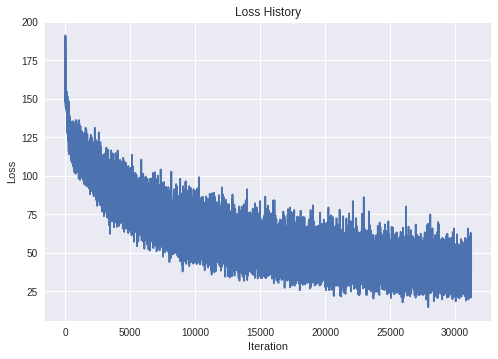

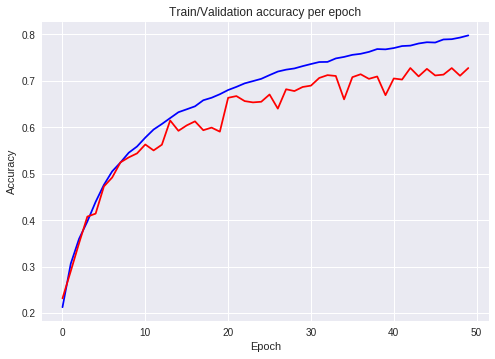

In [41]:
tf.reset_default_graph() # clear old variables

# The first dim is None, and it is set automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

pred = complex_model(X, y, is_training)

loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), pred) # define our loss
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3) # Adam optimizer with 1e-3 learning rate

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(loss)

#Below we'll create a session and train the model over 50 epochs.    
with tf.Session() as sess:
    with tf.device("/gpu:0") as dev: #training our model on GPU
        sess.run(tf.global_variables_initializer())
        run_model(sess, pred, X_train, y_train, X_val, y_val, 50, 
                  64, 200, plot_losses=True, plot_accuracies=True)
        
        